# Shazam Audio Search

In this homework you will implement a Shazam audio search engine.  

I have provided a skeleton of the code below, and you will fill in any sections marked with '### START CODE BLOCK ###' and '### END CODE BLOCK ###'.  Please do not change the code outside of these markers.  In particular, do not define any new functions, change the code decomposition, or modify function inputs, outputs, or default values.  Note that this code is written for ease of understanding and ease of grading, not for efficiency.

I have provided sample outputs for you to verify when your function is implemented correctly.  I have also provided a reference implementation (without source code) in case you get stuck.  If you are unable to implement a function correctly, you may replace `nameOfFunction(arg1, arg2)` with `hw3_solns.nameOfFunction(arg1, arg2)`.  This will allow you to move on even if you cannot implement a function correctly.

Once you have completed this assignment, please run your notebook from beginning to end, make sure all outputs and plots are showing in the notebook, save your notebook, and then submit on Gradescope.  Also, make sure to include both partners' names at the top of your notebook.

Partner 1 Name: Rafael Burger

Number of hours spent (Partner 1): __________

Partner 2 Name: Dan Fonseca

Number of hours spent (Partner 2): __________

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy.signal import stft
from scipy.io.wavfile import read
import glob
import subprocess
import os.path
import pickle
from collections import defaultdict
import hw3_solns

### Step 1: Extract fingerprints (40 points)

The first step is to create a function that can extract fingerprints from an audio file.  

In [4]:
def extractFingerprints(mp3file, sr = 22050, winsz = 2048, hop = 512, regionH = 128, regionW = 40, maxDiffFrms = 120, timeDiffQuant = 2):
    """
    Extract fingerprints from an audio file.
    
    Arguments:
    
    mp3file -- string specifying the full path of the mp3 file
    sr -- desired sampling rate
    winsz -- size of the STFT analysis window in samples
    hop -- hop size of STFT in samples
    regionH -- height of the rectangular region used to select maxima
    regionW -- width of the rectangular region used to select maxima
    maxDiffFrms -- maximum allowable time difference (in frames) between peaks in a pair
    timeDiffQuant -- quantization factor applied to time differences between pairs of peaks
    
    Returns:
    
    result -- a list of (m,fp) tuples where fp is the fingerprint value (an integer) and m is the frame index
    specifying when the fingerprint occurs in time.  The list of tuples is non-decreasing in m.
    """
    # You don't need to change anything here, you'll modify the below functions.
    peaks = getSpectralPeaks(mp3file, sr, winsz, hop, regionH, regionW)
    pairs = getPeakPairs(peaks, maxDiffFrms)
    result = calculateFingerprints(peaks, pairs, timeDiffQuant)
    return result

In the getSpectralPeaks function, you should
- calculate the one-sided STFT
- divide the STFT into rectangular neighborhood regions (you may ignore fragments at the edges)
- determine the location of the spectral maximum in each neighborhood region
- filter out any neighborhood maxima that are not local maxima (i.e. the maximum of the neighborhood region centered around the peak)
- sort the peaks by time in non-decreasing order

This function uses `getMaxIndex` and `isLocalMax`.

Hint: It can be confusing to think about which indices correspond to what in `S`. Remember that rows are the y coordinates and columns are the x coordinates.

In [5]:
def getSpectralPeaks(mp3file, sr = 22050, winsz = 2048, hop = 512, regionH = 128, regionW = 40):    
    """
    Determine the locations in time and frequency of spectral peaks in the spectrogram.
    
    Arguments:
    mp3file -- string specifying the full path of the mp3 file
    sr -- the desired sampling rate
    winsz -- size of the STFT analysis window in samples
    hop -- hop size of STFT in samples
    regionH -- height of the rectangular region used to select maxima
    regionW -- width of the rectangular region used to select maxima
    
    Returns:
    peaks_sorted -- a list of (m, k) tuples where m specifies the frame offset of the peak and
       k specifies the frequency bin of the peak.  The tuples are sorted by m in non-decreasing order.
    """

    Y, sr  = lb.load(mp3file, sr = sr)
    f, t, S = stft(Y, fs = sr, nperseg = winsz, noverlap = winsz - hop)
    Smag = np.abs(S)
    height, width = S.shape
    peaks = []
    
    ### START CODE BLOCK ###
    for x in range(0, width, regionW):
        for y in range(0, height, regionH):
            if (x + regionW) <= width and (y + regionH < height):
                region = Smag[y:min(y+regionH, height), x:min(x+regionW, width)] 
                col, row = getMaxIndex(region, y, x)
                if isLocalMax(row, col, Smag, regionH, regionW):
                    peaks.append((col, row))
    sorted_peaks = sorted(peaks)
    ### END CODE BLOCK ###

    return sorted_peaks

In the getMaxIndex function, you should
* Find the index of the maximum in `region`
* Translate this index to the absolute indexing using `x` and `y`

Be careful here about how you use the indices of `region`: in our indexing scheme, the point (i,j) is found at `region[j][i]`.

This function is called by `getSpectralPeaks`.

Hint: If you find the appropriate numpy functions, you can write this in only a few lines. The function `numpy.unravel_index()` is useful here.

In [6]:
def getMaxIndex(region, row, col):
    """
    Determine the index of the maximum of a region and translate it back to the original coordinate scheme.
    
    Arguments:
    region -- a matrix to find the maximum of
    row -- the absolute row number of the bottom left corner of 'region'
    col -- the absolute col number of the bottom left corner of 'region'
    
    Returns:
    m -- the absolute column of the max
    k -- the absolute row of the max
    """
    
    ### START CODE BLOCK ###

    ind = np.argmax(region)
    numrows, numcols = np.shape(region)
    rownum = ind // numcols
    colnum = ind % numcols
    m = colnum + col
    k = rownum + row

    ### END CODE BLOCK ###
    
    return m, k

In the isLocalMax function, you should:
- determine the rectangular neighborhood region centered around the specified (row,col) element of matrix S (note that at the edges of S, this region may not be fully centered around the element)
- return True if the specified element is the maximum of this centered neighborhood region

This function is called by getSpectralPeaks()

Hint: You need to "clamp" the region around (row, col) if it exceeds the boundaries of `S`. Python built-in functions will be helpful here. Consider using `max`, for example.

In [7]:
def isLocalMax(row, col, S, regionH, regionW):
    '''
    Return true if the specified element in S is the maximum of a rectangular region centered around it.
    This is a helper function used to filter out neighborhood peaks that are not true local maxima.
    
    Arguments:
    
    row -- the row of the specified element
    col -- the column of the specified element
    S -- the matrix
    regionH -- the height of the rectangular region in rows
    regionW -- the width of the rectangular region in columns
    
    Returns:
    
    A boolean indicating if the specified element is the local maximum of a rectangular region centered
    around it.  The rectangular region extends from from rows [row - regionH/2, row + regionH/2) and
    columns [col - regionW/2, col + regionW/2).
    '''

    ### START CODE BLOCK ###
    isMax = True

    rowStart = max(0, (row-regionH//2))
    rowStop = min(S.shape[0], row+regionH//2)
    
    colStart = max(0, (col-regionW//2))
    colStop = min(S.shape[1], col+regionW//2)
    
    if np.max(S[rowStart:rowStop, colStart:colStop]) != S[row, col]:
        isMax = False
                
    ### END CODE BLOCK ###

    return isMax

In the getPeakPairs function, you should:
- iterate through the sorted list of peaks
- find all pairs of peaks that have a time difference <= maxDiff
- construct a list of tuples (i,j) containing the peak pair indices where i < j

In [8]:
def getPeakPairs(peaks, maxDiff):
    """
    Return a list of all peak pairs that satisfy the maximum time difference condition.
    
    Arguments:
    peaks -- a list of (m,k) tuples specifying the frame offset and frequency bin of peaks.  The peaks
       are sorted in m in non-decreasing order.
    maxDiff -- the maximum allowable time difference between peaks in a pair
    
    Returns:
    pairs -- a list of (i,j) tuples specifying the indices of peak pairs, where i and j refer to indices
       in the given list of peaks.  This list of tuples should be non-decreasing in i.
    """
    pairs = []


    ### START CODE BLOCK ###
    mvals = [p[0] for p in peaks]

    for i in range(len(peaks)):
        for j in range(i+1,len(peaks)):
            if abs(peaks[i][0]-peaks[j][0]) <= maxDiff:
                pairs.append((i, j))
    ### END CODE BLOCK ###
    
    return pairs

In the calculateFingerprints function, you should:
- iterate through the peak pairs
- compute the fingerprint integer value for each peak pair
- store the fingerprint integer value and time offset in a list

Note that this function should call the packIntoInt() function.

In [9]:
def calculateFingerprints(peaks, pairs, timeDiffQuant):
    """
    Calculate a list of fingerprints on a set of peak pairs.
    
    Arguments:
    peaks -- a list of (m,k) tuples specifying the frame offset and frequency bin of peaks.  The peaks
       are sorted in m in non-decreasing order.
    pairs -- a list of (i,j) tuples specifying the indices of peak pairs.  This list of tuples is
       non-decreasing in i.
    timeDiffQuant -- quantization factor applied to time differences between pairs of peaks
       
    Returns:
    result -- a list of (m, fp) tuples where m specifies the frame offset of the fingerprint (i.e. the
       anchor peak) and fp specifies the fingerprint value (integer)
    """
    result = []

    ### START CODE BLOCK ##

    # Iterate through the peak pairs
    for i, j in pairs:
        # Compute the fingerprint value for each peak pair
        f1 = peaks[i][1]
        f2 = peaks[j][1]
        timediff = np.abs(peaks[i][0] - peaks[j][0])
        freqInt = packIntoInt(f1, f2, timediff, timeDiffQuant)
        
        result.append((peaks[i][0], freqInt))


    return result

In the packIntoInt function, you should:
- store f1 in the first 10 bits
- store f2 in the next 10 bits
- store the quantized time difference in the remaining bits

Note that you can shift an integer to the left by n bits by multiplying it by 2^n.

In [10]:
def packIntoInt(f1, f2, timediff, quant_factor):
    """
    Calculate the fingerprint value of a peak pair and package into a single integer value.
    
    Arguments:
    f1 -- frequency bin of anchor peak
    f2 -- frequency bin of non-anchor peak
    timediff -- time difference between peaks (in frames)
    quant_factor -- quantization factor applied to the time difference
    
    Returns:
    fp -- a single integer that specifies the fingerprint value, where the first 10 bits specify
       f1, the next 10 bits specify f2, and the remaining bits specify the quantized time difference.
    """
    f1rep = f1 * np.power(2, 0)
    f2rep = f2 * np.power(2,10)
    qtdrep = timediff//quant_factor * np.power(2,20)

    
    ### START CODE BLOCK ###
    fp = f1rep + f2rep + qtdrep
    ### END CODE BLOCK ###

    return fp

Below I have included some sample outputs for you to verify that your implementation is correct.

In [11]:
a = np.zeros((4,5))
a[2,4] = 1
getMaxIndex(a, 10, 20)

(24, 12)

(24, 12)

In [12]:
peaks = getSpectralPeaks('refs/005936.mp3')
peaks[0:5], len(peaks)

([(3, 574), (3, 944), (11, 850), (64, 24), (86, 507)], 97)

([(3, 574), (3, 944), (11, 850), (64, 24), (86, 507)], 97)

In [13]:
pairs = getPeakPairs(peaks, 120)
pairs[0:10], len(pairs)

([(0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (0, 6),
  (1, 2),
  (1, 3),
  (1, 4),
  (1, 5)],
 825)

([(0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (0, 6),
  (1, 2),
  (1, 3),
  (1, 4),
  (1, 5)],
 825)

In [14]:
packIntoInt(34, 240, 73, 2)

37994530

37994530

In [15]:
fps = calculateFingerprints(peaks, pairs, 2)
fps[0:8], len(fps)

([(3, 967230),
  (3, 5065278),
  (3, 31482430),
  (3, 43511358),
  (3, 43790910),
  (3, 50347582),
  (3, 5065648),
  (3, 31482800)],
 825)

([(3, 967230),
  (3, 5065278),
  (3, 31482430),
  (3, 43511358),
  (3, 43790910),
  (3, 50347582),
  (3, 5065648),
  (3, 31482800)],
 825)

In [16]:
fps = extractFingerprints('refs/005936.mp3')
fps[0:8], len(fps)

([(3, 967230),
  (3, 5065278),
  (3, 31482430),
  (3, 43511358),
  (3, 43790910),
  (3, 50347582),
  (3, 5065648),
  (3, 31482800)],
 825)

([(3, 967230),
  (3, 5065278),
  (3, 31482430),
  (3, 43511358),
  (3, 43790910),
  (3, 50347582),
  (3, 5065648),
  (3, 31482800)],
 825)

### Construct database (10 points)

Now we will construct our database of fingerprints.

In the constructDatabase function, you will:
- iterate through all mp3 files in the directory (hint: use `glob`)
- extract a list of fingerprints from each file
- store the fingerprint information in the dictionary d as an inverted index

Note that this function should call the extractFingerprints() function.

In [17]:
def constructDatabase(indir):
    """
    Construct a database of fingerprints for all mp3 files in the specified directory.
    
    Arguments:
    indir -- directory containing mp3 files
    
    Returns:
    d -- database of fingerprints in the form a python dictionary, where the key is the fingerprint (integer)
        and the value is a list of (song, m) tuples specifying the name of the mp3 file (basename only) and
        the time offset in frames where the matching fingerprint occurs.
    """
    # a defaultdict is like a python dictionary, but if you have some 'key' that isn't in 'd',
    # 'd[key]' is initialized to a default value (in this case the empty list). This means it's
    # always safe to do 'd[key].append(value)'.
    d = defaultdict(list)

    ### START CODE BLOCK ###
    mp3_path = f'{indir}/*.mp3'
    mp3_files = glob.glob(mp3_path)
    
    for i in range(len(mp3_files)):
        file_name = os.path.basename(mp3_files[i])
        fingerprints = extractFingerprints(mp3_files[i])
        for m, fp in fingerprints:
            d[fp].append((file_name, m))

    return d

In [18]:
ref_dir = 'refs'
db = constructDatabase(ref_dir) # note that this may take a minute or so to run

Let's save the database to file for convenient access later.

In [19]:
with open('db.pkl','wb') as f:
    pickle.dump(db, f)

In [20]:
with open('db.pkl','rb') as f:
    db = pickle.load(f)

### Search (30 points)

Now we will process the audio queries in the queries/ folder.  These are random 10 second segments extracted from the reference tracks.

In the getMatchScore function, you will:
- get a list of scatterpoints and offsets for matching fingerprints by calling the `getOffsets` function
- convert the list of scatterpoints and offsets to numpy arrays
- compute a histogram of offsets with bin width 1.  The function `numpy.histogram` may be useful.
- calculate the match score as the maximum histogram count

Hint: Make sure your function handles the case when there are no matching fingerprints at all!

In [21]:
def getMatchScore(query_fps, db, songid, visualize = False):
    """
    Determine the match score between a set of query fingerprints and a single song in the database.
    
    Arguments:
    query_fps -- a list of tuples (m, fp) specifying the time offset (in frames) and value of 
       fingerprints extracted from an audio query
    db -- database of fingerprints
    songid -- the song of interest, specified as a filename (e.g. '005936.mp3')
    visualize -- if True, show a plot containing (a) a scatterplot of matching fingerprints for the
       given song, and (b) a histogram of offsets for matching fingerprints for the given song.
    
    Returns:
    matchScore -- a scalar indicating how well the query matches this song in the database
    """

    ### START CODE BLOCK ###        
    points, offsets = getOffsets(query_fps, db, songid)
    points = np.array(points)
    offsets = np.array(offsets)
    
    if len(points) > 0:
        binCounts, binEdges = np.histogram(offsets, bins=np.arange(offsets.min(), offsets.max()+2,1))
        matchScore = np.max(binCounts)
    else:
        matchScore = 0
    ### END CODE BLOCK ###
    
    if visualize:
        if len(points) == 0:
            print('No matching fingerprints')
        else:
            plt.subplot(121)
            plt.plot(points[:,0],points[:,1],'o')
            plt.title('Matching Fingerprints')
            plt.xlabel('Ref Time (frames)')
            plt.ylabel('Query Time (frames)')
            plt.subplot(122)
            plt.hist(offsets, bins=np.arange(offsets.min(), offsets.max()+2,1))
    
    return matchScore

In the `getOffsets` function, you will:
- iterate through the query fingerprints
- retrieve all matching fingerprints from the inverted index
- filter out any matching fingerprints from songs other than the one specified in songid
- create a list of (ref_offset, query_offset) tuples for matching fingerprints in songid
- return that list, as well as a list containing the (ref_offset - query_offset) differences

In [22]:
def getOffsets(query_fps, db, songid):
    """
    Find the offsets of matching fingerprints between a query and a database.
    
    Arguments:
    query_fps -- a list of tuples (m, fp) specifying the time offset (in frames) and value of 
       fingerprints extracted from an audio query
    db -- database of fingerprints
    songid -- the song of interest, specified as a filename (e.g. '005936.mp3')
    
    Returns:
    points -- a list of (ref_offset, query_offset) tuples
    offsets -- a list of (ref_offset - query_offset) values
    """
    
    points = []
    
    ### START CODE BLOCK ###
    offsets = None
    
    # Retrieve matching fingerprints
    matches = [(tuple[0], db[tuple[1]]) for tuple in query_fps]

    # Filter out any matching fingerprints from songs other than the one specified in songid
    filteredMatches = [(query_offset, [match for match in bucket if match[0] == songid]) for query_offset, bucket in matches]

    # Create a list of (ref_offset, query_offset) tuples for matching fingerprints in songid
    points = [(match[1], query_offset) for query_offset, matches in filteredMatches for match in matches]

    # List containing (ref_offset - query_offset) differences
    offsets = [np.abs(point[0] - point[1]) for point in points]
    ### END CODE BLOCK ###
    
    return points, offsets

In [23]:
testFinger = extractFingerprints('classdata/054156.mp3')

In [24]:
getOffsets(testFinger, db, '054156.mp3')

([(389, 84),
  (502, 197),
  (694, 217),
  (866, 217),
  (1211, 217),
  (866, 217),
  (694, 217),
  (866, 217),
  (1242, 249),
  (726, 250),
  (726, 250),
  (898, 250),
  (597, 293),
  (1114, 293),
  (769, 293),
  (942, 293),
  (597, 293),
  (769, 293),
  (942, 293),
  (1114, 293),
  (599, 295),
  (1116, 295),
  (800, 324),
  (972, 324),
  (800, 324),
  (726, 347),
  (694, 390),
  (866, 390),
  (1211, 390),
  (522, 390),
  (694, 390),
  (1039, 390),
  (726, 422)],
 [305,
  305,
  477,
  649,
  994,
  649,
  477,
  649,
  993,
  476,
  476,
  648,
  304,
  821,
  476,
  649,
  304,
  476,
  649,
  821,
  304,
  821,
  476,
  648,
  476,
  379,
  304,
  476,
  821,
  132,
  304,
  649,
  304])

In the findBestMatch function, you will:
- extract fingerprints from the specified query file
- iterate through all of the songs in the database and calculate a match score on each
- sort the songs in decreasing order of match score
- if verbose = True, print out the top 5 match scores and song names
- determine the song with highest match score

Note that this function should call the extractFingerprints() and getMatchScore() functions.

In [25]:
def findBestMatch(query_file, db, ref_dir, verbose = False):
    """
    Return the name of the mp3 file that has the highest match score.
    
    Arguments:
    query_file -- string specifying the query audio file
    db -- database of fingerprints
    ref_dir -- directory containing all of the reference files in the database
    verbose -- whether or not to print out the top 5 matches (for debugging) 
    
    Returns:
    bestmatch -- a string containing the name of the mp3 file with highest match score
    """
    
    ### START CODE BLOCK ###
    query_fps = extractFingerprints(query_file)

    mp3_path = f'{ref_dir}/*.mp3'
    mp3_files = glob.glob(mp3_path)

    scores = []
    for i in range(len(mp3_files)):
        ref_id = os.path.basename(mp3_files[i])
        scores.append((getMatchScore(query_fps, db, ref_id), ref_id))
    
    top5 = []
    for i in range(5):
        maxpair = max(scores)
        top5.append(maxpair[1])
        scores.pop(scores.index(maxpair))

    bestMatch = top5[0]

    if verbose:
        print("Top match scores:", top5)

    ### END CODE BLOCK ###
    
    return bestMatch

In the runBenchmark function, you will:
- iterate through all of the query files in the specified directory
- find the song with highest match score
- check if the predicted match is correct
- print out the accuracy across all queries

Note that this function should call the findBestMatch() function.

In [26]:
def runBenchmark(query_dir, ref_dir, db):
    """
    Run an entire benchmark and print out the accuracy of the system.
    
    Arguments:
    query_dir -- directory containing the query mp3 files
    ref_dir -- directory containing the reference mp3 files
    db -- database of fingerprints
    
    Returns:
    No return value.  Prints out the accuracy of the system.
    """
    mp3_path = f'{query_dir}/*.mp3'
    mp3_files = glob.glob(mp3_path)

    total_queries = 0
    correct_predictions = 0
    for file in mp3_files:
        # We iterate through the files in the query_dir
        # We call this function below, if the name of the file is the same as the one we're currently on, then it is a correct prediction 
        # so we add 1 to correct_prediction 
        prediction = findBestMatch(file, db, ref_dir)
        fileName = os.path.basename(file)
        print(prediction, fileName)
        if prediction == fileName:
            correct_predictions +=1
        
        total_queries += 1

    accuracy = correct_predictions / total_queries

    return print('Accuracy: %.2f %%' % (accuracy * 100.0))

Here are some sample outputs to verify that your implementation is correct.

149

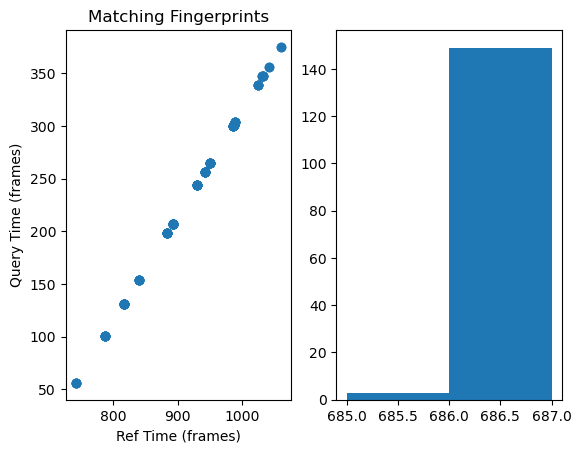

In [27]:
query_fps = extractFingerprints('queries/005936.mp3')
getMatchScore(query_fps, db, '005936.mp3', True)

149

<img src="figs/extractFingerprints.png">

In [28]:
getMatchScore(query_fps, db, '054156.mp3', True)

No matching fingerprints


0

No matching fingerprints

0

In [29]:
findBestMatch('queries/120208.mp3', db, ref_dir, True)

Top match scores: ['120208.mp3', '113934.mp3', '066076.mp3', '148610.mp3', '139536.mp3']


'120208.mp3'

Top match scores
120208.mp3 226,
066076.mp3 1,
113934.mp3 1,
114065.mp3 0,
071372.mp3 0

'120208.mp3'

In [30]:
runBenchmark('queries/', ref_dir, db)

005936.mp3 005936.mp3
006776.mp3 006776.mp3


019187.mp3 019187.mp3
019442.mp3 019442.mp3
038820.mp3 038820.mp3
049408.mp3 049408.mp3
054156.mp3 054156.mp3
054719.mp3 054719.mp3
057164.mp3 057164.mp3
066076.mp3 066076.mp3
071372.mp3 071372.mp3
074706.mp3 074706.mp3
077521.mp3 077521.mp3
081814.mp3 081814.mp3
096400.mp3 096400.mp3
108427.mp3 108427.mp3
108504.mp3 108504.mp3
110771.mp3 110771.mp3
113934.mp3 113934.mp3
114065.mp3 114065.mp3
115288.mp3 115288.mp3
119985.mp3 119985.mp3
120208.mp3 120208.mp3
120306.mp3 120306.mp3
123096.mp3 123096.mp3
126789.mp3 126789.mp3
127660.mp3 127660.mp3
133333.mp3 133333.mp3
139536.mp3 139536.mp3
148610.mp3 148610.mp3
Accuracy: 100.00 %


Accuracy: 100.00 %

### Test on class dataset (20 points)

Now we will run some experiments on real noisy data that our class will collect.

In this part, you will do the following:
- Each team will collect 4 cell phone recordings.  Please sign up for your four recordings in [this spreadsheet](https://docs.google.com/spreadsheets/d/1ZdhAxttyPslteLaBgijIcESvQTIqWawm7ExceIiF88Y/edit?usp=sharing).  For each recording, play the original audio recording from your laptop (or nicer speaker if you have one) and record approximately 10 seconds of the song on your cell phone.  Upload your four recordings to this [shared google drive folder](https://drive.google.com/drive/folders/1wQAZ_VL2lsaGNHS7FaHOL5z03TT_sfSY?usp=sharing), making sure to name them appropriately (they should have the same basename as the original audio recording).  Your four cell phone recordings should be uploaded to the folder by Saturday noon (-5 points if not done by then) to ensure everyone has enough time to run experiments before the homework deadline.
- Once our class has finished collecting the audio data, download the audio data from the shared google drive folder and save it into your homework directory.  When you unzip the file, it should create a directory called classdata.
- Run a benchmark on the real noisy queries.  Describe how the system behaves with real noisy queries vs clean queries.  What are the weaknesses of the system?  Use plots, figures, and/or data to support your answer.
- Describe one way that you could improve the performance of the system on the real noisy queries.  Explain the tradeoffs (if any) of your proposal, describe the intuition for why it would improve performance, and provide plots, figures, and/or data to support your answer.

Please make sure to include both your comments (in markdown cells) and your code and visualizations.

## Testing on Class Data

Before getting into any analysis, lets see how our model performs on real data: 

In [31]:
runBenchmark('classdata/', ref_dir, db)

148610.mp3 005936.mp3
006776.mp3 006776.mp3
019187.mp3 019187.mp3
019442.mp3 019442.mp3
038820.mp3 038820.mp3
049408.mp3 049408.mp3
054156.mp3 054156.mp3
049408.mp3 054719.mp3
057164.mp3 057164.mp3
066076.mp3 066076.mp3
071372.mp3 071372.mp3
074706.mp3 074706.mp3
127660.mp3 077521.mp3
148610.mp3 081814.mp3
148610.mp3 096400.mp3
148610.mp3 108427.mp3
110771.mp3 110771.mp3
113934.mp3 113934.mp3
114065.mp3 114065.mp3
115288.mp3 115288.mp3
074706.mp3 119985.mp3
148610.mp3 120208.mp3
148610.mp3 120306.mp3
148610.mp3 123096.mp3
Accuracy: 58.33 %


That's much worse (as expected, I suppose) than it performed on the perfect data. Why did it get so much worse? We can inspect this by comparing the match score of a perfect file and its corresponding database entry to the match score of a real file to its corresponding database entry. 

We'll compute and plot the match score for the perfect file and its database entry here: 

202

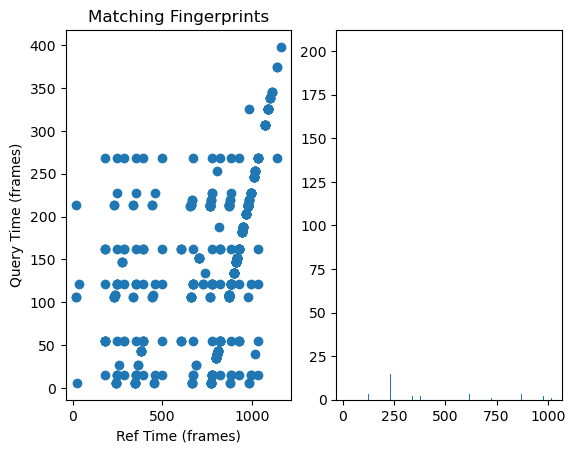

In [32]:
perfect_fps = extractFingerprints('queries/054719.mp3')
getMatchScore(perfect_fps, db, '054719.mp3', True)

In this case, there are a number of peaks, however there is a clear highest peak in the histogram that corresponds to the unity-slope offset line which can be seen in the offset plot. This high max-count gives this pair a high match score, which is why it was attributed correctly. 

Now, lets look at the match score between a real data file and its corresponding database entry: 

2

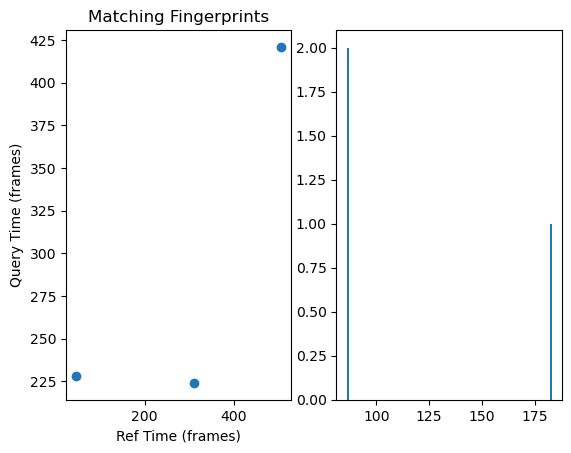

In [33]:
real_fps = extractFingerprints('classdata/054719.mp3')
getMatchScore(real_fps, db, '054719.mp3', True)

As you can see, there are very few matching fingerprints in the real data. It seems that with the introduction of real data, the ambient noise present is capable of drowning out some of the STFT peaks from which the fingerprints are computed. To add to this, not all of the remaining fingerprints lie upon the uniform-offset line. This case (which was misattributed by our software) and cases like it results in a very low match score between the file and its corresponding database entry. This is a problem, as random chance can lead to similarly low match scores between the same file and non-corresponding database entries, which results in misattribution. 

An example of this in action is shown here: 

3

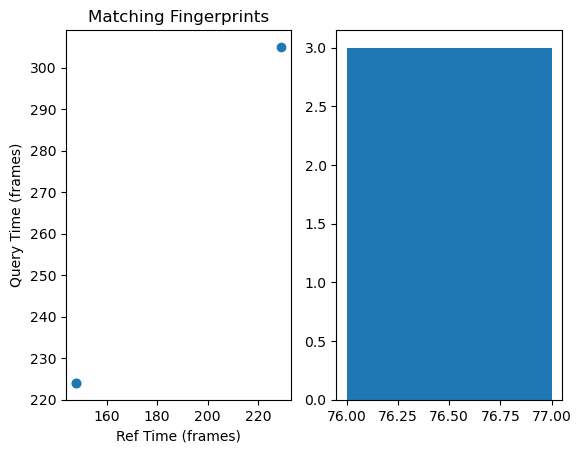

In [34]:
mismatched_fps = extractFingerprints('classdata/054719.mp3')
getMatchScore(mismatched_fps, db, '049408.mp3', True)

This plot shows that for the file discussed above, (054719.mp3), the match score with database entry 049408 was computed to be 3. This is due to random chance, and it exceeds the match score of 2 that was computed between 054719 and it's corresponding database entry. This illustrates that as background noise increases and fingerprints are lost, the risk of misattributing due to random chance offset agreement increases. 


These are likely not the only reason for the model's poor performance. Here we will discuss implementation decisions that we believe could be leading to problems, and improvements we could make.  